# Fake News Detection 

**Shruthi AK**

**12/09/2024**

**Introduction**

The proliferation of fake news poses significant challenges to the integrity of information disseminated online. As fake news spreads quickly and influences public opinion, it becomes crucial to develop robust systems to detect and filter out such content. This project aims to create an effective fake news classification system using a combination of machine learning (ML) and deep learning (DL) models. By leveraging both traditional and advanced techniques, we seek to improve the accuracy and reliability of fake news detection.

**Dataset**

About the Dataset
This project is based on the dataset comprising true and false news articles with columns for title, text, subject, and date. The dataset includes21,4172 true news articles and23,4813 false news articles. The focus will be on preprocessing this data effectively and implementing the models to achieve the best possible performance in terms of accuracy.


In [18]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrut\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading

In [5]:
# Load CSV files
true_news_df = pd.read_csv('True.csv')
false_news_df = pd.read_csv('Fake.csv')

## Data Preparation

In [6]:
# Combine into a single DataFrame with labels
true_news_df['label'] = 1
false_news_df['label'] = 0

# Concatenate DataFrames
df = pd.concat([true_news_df, false_news_df], ignore_index=True)

# Check the first few rows
print(df.head())

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  


In [7]:
# Check the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


**There are No Missing Values**

In [8]:
# Check the target variable value counts
df['label'].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

In [34]:
df['label'].value_counts(normalize=True)

label
0    0.522985
1    0.477015
Name: proportion, dtype: float64

True News: 47.7% of the total dataset

Fake News: 52.3% of the total dataset

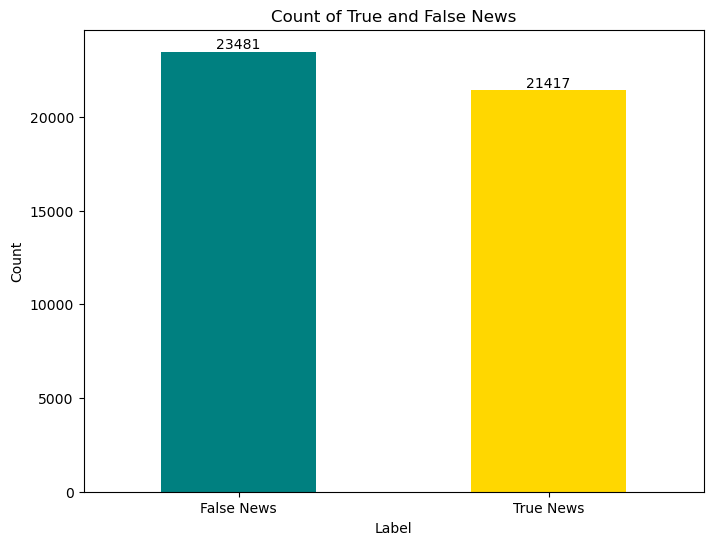

In [33]:
# Display the count of values for the label
label_counts = df['label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
bars = label_counts.plot(kind='bar', color=['teal', 'gold'])

# Adding count numbers on top of the bars
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, int(height), ha='center', va='bottom')

# Customize the plot
plt.title('Count of True and False News')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0, ticks=[0, 1], labels=['False News', 'True News'])
plt.show()

The class distribution shows that the dataset is relatively balanced, with a slight majority of fake news samples. The difference in the number of samples between the two classes is not substantial enough to warrant resampling. Hence we proceed with the data as it is.

## Data Preprocessing

In [10]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Convert to lower case
    tokens = [word.lower() for word in tokens]
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin tokens into a single string
    return ' '.join(tokens)

# Apply preprocessing to the 'text' column
df['cleaned_text'] = df['text'].apply(preprocess_text)

## Data Splitting

In [11]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

## Vectorization

In [15]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## ML Models

### 1. Logistic Regression
Logistic Regression is a linear model used for binary classification tasks. It estimates the probability that a given input belongs to a particular class. The logistic function (sigmoid) is used to map predicted values to probabilities.

In [11]:
# Initialize Logistic Regression model
logistic_regression = LogisticRegression()

# Train the model
logistic_regression.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_lr = logistic_regression.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report ( Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

Classification Report ( Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4650
           1       0.98      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### 2. Multinomial Naive Bayes
Multinomial Naive Bayes is a probabilistic algorithm based on Bayes' theorem. It assumes independence among features and is particularly effective for text classification tasks.

In [12]:
# Initialize the model
ml_model = MultinomialNB()

# Train the model
ml_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = ml_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report (Naive Bayes):")
print(classification_report(y_test, y_pred))

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4650
           1       0.93      0.93      0.93      4330

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



### 3. Support Vector Machines (SVM)
SVM is a powerful classification algorithm that finds the hyperplane that best separates the classes in the feature space. It is effective in high-dimensional spaces and for cases where the number of dimensions exceeds the number of samples.

In [13]:
# Initialize the model
svm_model = SVC(kernel='linear')

# Train the model
svm_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred))

Classification Report (SVM):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4650
           1       0.99      1.00      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### 4. Random Forest Classifier
Random Forest is an ensemble learning method that constructs multiple decision trees and merges them to get a more accurate and stable prediction. It handles overfitting well and provides a good balance between bias and variance.

In [13]:
# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred))

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4650
           1       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### 5. Gradient Boosting Classifier
Gradient Boosting is an ensemble technique that builds models sequentially, each trying to correct the errors of the previous one. It combines weak learners to create a strong learner.

In [15]:
# Initialize the model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model
gb_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = gb_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred))

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4650
           1       0.99      1.00      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



## Tokenization and Padding
First, we need to tokenize the text data and then pad the sequences so they all have the same length. We'll use Tokenizer from Keras for this purpose.

In [16]:
# Define parameters
max_features = 10000  # Vocabulary size
max_len = 200         # Maximum length of sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_features)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

# Pad sequences to the same length
X_train_pad = pad_sequences(X_train_tokenized, maxlen=max_len)
X_test_pad = pad_sequences(X_test_tokenized, maxlen=max_len)

## Deep Learning Models

### 1. Deep Neural Network (DNN)
DNNs are multi-layer neural networks that can model complex relationships in the data. They consist of input, hidden, and output layers, with each layer containing multiple neurons.

In [17]:
# Define model architecture
dnn_model = Sequential([
    Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = dnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = dnn_model.evaluate(X_test_pad, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.8949 - loss: 0.2276 - val_accuracy: 0.9829 - val_loss: 0.0464
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.9987 - loss: 0.0058 - val_accuracy: 0.9894 - val_loss: 0.0354
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9999 - loss: 0.0010 - val_accuracy: 0.9882 - val_loss: 0.0411
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 1.0000 - loss: 8.8648e-04 - val_accuracy: 0.9878 - val_loss: 0.0439
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9999 - loss: 7.7886e-04 - val_accuracy: 0.9878 - val_loss: 0.0474
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9881 - loss: 0.0451
Loss: 0.04560296982526779, Accuracy: 0.9888641238212585


### 2. Long Short-Term Memory (LSTM)
LSTM is a type of recurrent neural network (RNN) capable of learning long-term dependencies. It is well-suited for sequence classification tasks like text classification.

In [18]:
# Define model architecture
lstm_model = Sequential([
    Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 243s 522ms/step - accuracy: 0.8975 - loss: 0.2506 - val_accuracy: 0.9738 - val_loss: 0.0766
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 226s 503ms/step - accuracy: 0.9855 - loss: 0.0490 - val_accuracy: 0.9844 - val_loss: 0.0573
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 240s 536ms/step - accuracy: 0.9864 - loss: 0.0431 - val_accuracy: 0.9897 - val_loss: 0.0353
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 248s 552ms/step - accuracy: 0.9939 - loss: 0.0188 - val_accuracy: 0.9747 - val_loss: 0.0743
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 251s 527ms/step - accuracy: 0.9924 - loss: 0.0264 - val_accuracy: 0.9893 - val_loss: 0.0385
281/281 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.9872 - loss: 0.0412
Loss: 0.0416342057287693, Accuracy: 0.9877505302429199


### 3. Bidirectional LSTM
Bidirectional LSTM (BiLSTM) captures information from both past and future states, making it more effective for sequence classification tasks.

In [19]:
# Define model architecture
bi_lstm_model = Sequential([
    Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128)),
    Dense(1, activation='sigmoid')
])

# Compile the model
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = bi_lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = bi_lstm_model.evaluate(X_test_pad, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 302s 653ms/step - accuracy: 0.8973 - loss: 0.2408 - val_accuracy: 0.9749 - val_loss: 0.0718
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 281s 625ms/step - accuracy: 0.9818 - loss: 0.0565 - val_accuracy: 0.9823 - val_loss: 0.0596
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 269s 598ms/step - accuracy: 0.9865 - loss: 0.0410 - val_accuracy: 0.9859 - val_loss: 0.0420
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 305s 680ms/step - accuracy: 0.9943 - loss: 0.0161 - val_accuracy: 0.9811 - val_loss: 0.0494
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 313s 697ms/step - accuracy: 0.9984 - loss: 0.0065 - val_accuracy: 0.9900 - val_loss: 0.0322
281/281 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.9871 - loss: 0.0399
Loss: 0.03403124213218689, Accuracy: 0.988418698310852


## Model Comparison

### Best ML Model

As all the ML models that we have built, other than Multinomial Naive Bayes, are providing the same accuracy and other metrics like precision, recall, and F1-score, I have chosen the Random Forest Classifier for the following reasons:

**Random Forest Classifier**

Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) of the individual trees. The idea behind Random Forest is to create a 'forest' of trees, each trained on a random subset of data and features, and then combine their predictions to improve accuracy and control overfitting.

**Advantages of Random Forest:**

Reduced Overfitting: By averaging the predictions of multiple trees, Random Forest reduces the risk of overfitting, which is a common problem in decision trees.

Versatility: It can handle both classification and regression tasks and works well with high-dimensional data.

Feature Importance: Provides insights into feature importance, aiding in feature selection and understanding the model.

**Performance Metrics:**

Accuracy: Random Forest achieved an accuracy of 99%, which is on par with other models but with additional benefits of robustness and interpretability.

Precision, Recall, F1-Score: These metrics were equally high, indicating that Random Forest performs well in identifying both true positives and negatives.

**Why Choose Random Forest Classifier?**

Interpretability:

Feature Importance: Random Forest provides feature importance scores, which help in understanding the influence of each feature on the predictions.
Partial Dependence Plots: These plots can show the effect of a single feature on the target prediction, making the model somewhat interpretable.

Robustness:

Handling Overfitting: Random Forest reduces the risk of overfitting by averaging the results of multiple decision trees, which makes it more robust compared to single models.
Handling Missing Values: Random Forest can handle missing values naturally by splitting on other features.

Performance:

Non-linear Relationships: Random Forest can capture non-linear relationships between features and the target variable, often leading to better performance compared to linear models.
High Accuracy: Random Forest tends to achieve high accuracy, especially with well-tuned hyperparameters.

Efficiency:

Training Time: While slower than Logistic Regression, Random Forest is relatively faster than Gradient Boosting algorithms, making it a good compromise.
Parallel Processing: Random Forest can be parallelized, leveraging multi-core processors for faster training and prediction.

Scalability:

Large Datasets: Random Forest can handle large datasets efficiently, making it suitable for your project.

**Result**

Choosing the Random Forest Classifier is a balanced decision considering the high accuracy, interpretability, and robustness. It provides a good trade-off between performance and usability, making it suitable for the fake news detection project.

### Best DL Model

As all the deep learning models that we have built are providing similar accuracy and other metrics, I have chosen the Bidirectional LSTM for the following reasons:

**Bidirectional LSTM**

Bidirectional Long Short-Term Memory (LSTM) is an advanced version of the traditional LSTM model, which processes data in both forward and backward directions. This helps in capturing contextual information from both the past and the future, leading to a better understanding of the sequence.

**Advantages of Bidirectional LSTM:**

Contextual Understanding:

Bidirectional Processing: It captures dependencies from both directions, which is beneficial for text data where context is crucial.

Improved Performance:

Lower Loss: The Bidirectional LSTM achieved the lowest loss among the models, indicating better fit and potentially better generalization to unseen data.

High Accuracy: It achieved high accuracy (98.84%), which is competitive with the other models.

Handling Sequential Data:

Complex Patterns: It captures complex sequential patterns, making it ideal for tasks involving text data.

Performance Metrics:

Accuracy: The Bidirectional LSTM achieved an accuracy of 98.84%, which is competitive with the other models but with a better loss value.

Loss: The model achieved the lowest loss (0.0340), indicating a better fit to the data.

**Why Choose Bidirectional LSTM?**

Contextual Awareness:

Forward and Backward Processing: The bidirectional nature of the model allows it to understand the context better, which is crucial for fake news detection.

Performance Metrics:

Lower Loss and High Accuracy: The combination of high accuracy and low loss makes it a robust choice for the task.

Handling Sequential Data:

Capturing Dependencies: It captures sequential dependencies better than a unidirectional LSTM, leading to improved performance in NLP tasks.

**Result**

Choosing the Bidirectional LSTM model is a balanced decision considering its ability to understand complex sequential data, high accuracy, and lower loss. It provides a robust and comprehensive solution for the fake news detection project.

## Conclusion

This project demonstrates the effectiveness of using machine learning and deep learning models for fake news classification. Both the Random Forest Classifier and Bidirectional LSTM showed promising results. Future work could explore the integration of more sophisticated NLP techniques and the use of larger datasets to further improve model performance.